In [8]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import OPTICS, cluster_optics_dbscan
from sklearn.manifold import TSNE
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import AffinityPropagation

from itertools import cycle

import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [9]:
df_stock = pd.read_csv('df_techIndi.csv')

# Explicitly convert 'date' to datetime format, assuming the timezone is to be considered
df_stock['date'] = pd.to_datetime(df_stock['date'], utc=True).dt.tz_convert('America/New_York').dt.date
df_stock['date'] = pd.to_datetime(df_stock['date'])

# Set 'symbol' and 'date' as a multi-index
df_stock.set_index(['symbol', 'date'], inplace=True)

# Display the DataFrame
df_stock

open       high        low   adjclose     volume  \
symbol date                                                                
ACON   2022-09-06  18.080000  19.200001  17.120001  18.400000     3050.0   
       2022-09-07  18.559999  18.719999  17.280001  18.719999     2675.0   
       2022-09-08  19.200001  20.799999  17.600000  19.680000    15175.0   
       2022-09-11  19.040001  22.559999  19.040001  21.760000    13356.0   
       2022-09-12  21.120001  21.600000  18.719999  19.840000     5250.0   
...                      ...        ...        ...        ...        ...   
ZVSA   2024-04-23   5.990000   6.200000   5.740000   6.100000    32860.0   
       2024-04-24   5.780000   6.300000   5.600000   6.080000    40900.0   
       2024-04-25   5.440000   6.200000   4.440000   4.990000   440500.0   
       2024-04-28   6.530000   6.700000   5.150000   5.770000  8062900.0   
       2024-04-29   5.590000   5.590000   5.095000   5.290000   189100.0   

                        DEMA        EMA  HT_TRENDLINE       KAMA         MA  \
symbol date                                                                   
ACON   2022-09-06  17.593392  17.164137     17.519047  16.090902  17.053333   
       2022-09-07  17.759978  17.264515     17.835920  16.142636  17.197333   
       2022-09-08  18.029634  17.420353     18.093653  16.214931  17.347200   
       2022-09-11  18.532217  17.700330     18.393387  16.371718  17.555200   
       2022-09-12  18.745727  17.838373     18.590720  16.436716  17.707200   
...                      ...        ...           ...        ...        ...   
ZVSA   2024-04-23   6.144420   6.988913      6.977292   6.916742   7.212000   
       2024-04-24   6.085408   6.930273      6.915812   6.880881   7.154333   
       2024-04-25   5.897633   6.805094      6.827805   6.728070   7.054333   
       2024-04-28   5.826927   6.738314      6.721743   6.688282   6.986333   
       2024-04-29   5.704875   6.644874      6.608488   6.572261   6.879667   

                   ...          ADOSC  HT_DCPERIOD  HT_DCPHASE  AVGPRICE  \
symbol date        ...                                                     
ACON   2022-09-06  ...  -34349.344762    15.181595  280.274013  18.20000   
       2022-09-07  ...  -27225.029405    15.160085  312.724285  18.32000   
       2022-09-08  ...  -20387.009344    15.069376   17.870872  19.32000   
       2022-09-11  ...  -13418.288497    14.899989   81.865758  20.60000   
       2022-09-12  ...   -9718.815371    14.699255  108.713298  20.32000   
...                ...            ...          ...         ...       ...   
ZVSA   2024-04-23  ...  -20424.471118    22.580023   -9.354736   6.00750   
       2024-04-24  ...   -9544.799636    23.023356   -7.660383   5.94000   
       2024-04-25  ...  -56786.008199    22.799337   -6.386364   5.26750   
       2024-04-28  ... -584043.229138    22.283037   -1.970698   6.03750   
       2024-04-29  ... -759407.466597    21.848365    2.463822   5.39125   

                    MEDPRICE   TYPPRICE  WCLPRICE       ATR       NATR  \
symbol date                                                              
ACON   2022-09-06  18.160001  18.240000  18.28000  3.173335  17.246384   
       2022-09-07  18.000000  18.240000  18.36000  3.049525  16.290198   
       2022-09-08  19.200000  19.360000  19.44000  3.060273  15.550168   
       2022-09-11  20.800000  21.120000  21.28000  3.093111  14.214662   
       2022-09-12  20.160000  20.053333  20.00000  3.089317  15.571154   
...                      ...        ...       ...       ...        ...   
ZVSA   2024-04-23   5.970000   6.013333   6.03500  0.753465  12.351887   
       2024-04-24   5.950000   5.993333   6.01500  0.749646  12.329707   
       2024-04-25   5.320000   5.210000   5.15500  0.821814  16.469225   
       2024-04-28   5.925000   5.873333   5.84750  0.885256  15.342394   
       2024-04-29   5.342500   5.325000   5.31625  0.870238  16.450621   

                     TRANGE  
symbol date              

In [10]:
# Split data into train and test sets
# Assuming you want to train on the first month and test on the second
train_df = df_stock.loc[pd.IndexSlice[:, '2023-05-01':'2023-12-31'], :]
test_df = df_stock.loc[pd.IndexSlice[:, '2024-01-01':'2024-04-29'], :]

In [11]:
# Function to normalize data for each symbol using StandardScaler
def standardize_data(group):
    scaler = StandardScaler()
    numerical_features = group.select_dtypes(include=['float64', 'int64'])
    group[numerical_features.columns] = scaler.fit_transform(numerical_features)
    return group

train_df_standardized = train_df.groupby(level='symbol').apply(standardize_data)
test_df_standardized = test_df.groupby(level='symbol').apply(standardize_data)


train_df_standardized = train_df_standardized.reset_index(level=1, drop=True)
test_df_standardized = test_df_standardized.reset_index(level=1, drop=True)
train_df_standardized

open      high       low  adjclose    volume      DEMA  \
symbol date                                                                     
ACON   2023-05-01  0.598880  0.456183  0.484273  0.463798 -0.146340  0.950852   
       2023-05-02  0.410652  0.954439  0.607836  1.215317 -0.102938  0.987442   
       2023-05-03  1.012983  0.847669  0.978525  0.861198 -0.154094  0.975578   
       2023-05-04  0.888752  0.812080  0.813774  0.900544 -0.164789  0.969634   
       2023-05-07  0.674172  0.616337  0.854962  0.703812 -0.164772  0.939201   
...                     ...       ...       ...       ...       ...       ...   
ZVSA   2023-12-21 -1.229940 -1.239136 -1.235499 -1.238303 -0.124350 -0.880777   
       2023-12-25 -1.234408 -1.239528 -1.238148 -1.240187 -0.043436 -0.890895   
       2023-12-26 -1.228315 -1.231886 -1.241679 -1.232023  0.140655 -0.898719   
       2023-12-27 -1.226283 -1.213273 -1.228657 -1.211298  0.279631 -0.903058   
       2023-12-28 -1.198455 -1.210921 -1.222256 -1.221556 -0.016170 -0.907738   

                        EMA  HT_TRENDLINE      KAMA        MA  ...     ADOSC  \
symbol date                                                    ...             
ACON   2023-05-01  0.865325      0.963342  0.867373  0.851090  ... -4.409466   
       2023-05-02  0.891211      0.959449  0.869641  0.854973  ... -3.530613   
       2023-05-03  0.887675      0.954021  0.869640  0.845964  ... -2.812789   
       2023-05-04  0.887450      0.947605  0.869945  0.837577  ... -2.218218   
       2023-05-07  0.871822      0.939660  0.868237  0.820492  ... -1.732388   
...                     ...           ...       ...       ...  ...       ...   
ZVSA   2023-12-21 -0.853183     -0.791111 -0.766478 -0.751303  ... -0.542492   
       2023-12-25 -0.858910     -0.798978 -0.771012 -0.755442  ... -0.386089   
       2023-12-26 -0.864041     -0.806599 -0.781693 -0.762083  ... -0.188873   
       2023-12-27 -0.868265     -0.815783 -0.788301 -0.767580  ...  0.069646   
       2023-12-28 -0.872501     -0.824264 -0.794822 -0.773116  ...  0.161984   

                   HT_DCPERIOD  HT_DCPHASE  AVGPRICE  MEDPRICE  TYPPRICE  \
symbol date                                                                
ACON   2023-05-01    -1.046754    1.650042  0.503965  0.471799  0.469758   
       2023-05-02    -1.070607    1.916956  0.803811  0.798162  0.936118   
       2023-05-03    -0.969116    2.063621  0.929148  0.913349  0.897362   
       2023-05-04    -0.771900    2.185715  0.858766  0.817360  0.845688   
       2023-05-07    -0.645961    2.375803  0.712218  0.730970  0.722962   
...                        ...         ...       ...       ...       ...   
ZVSA   2023-12-21     0.701856   -0.400673 -1.237841 -1.239615 -1.239640   
       2023-12-25     0.696126   -0.313927 -1.240173 -1.241071 -1.241238   
       2023-12-26     0.677862   -0.221639 -1.235406 -1.238680 -1.236930   
       2023-12-27     0.647974   -0.075083 -1.221780 -1.222667 -1.219347   
       2023-12-28     0.578715    0.031400 -1.215097 -1.218404 -1.219903   

                   WCLPRICE       ATR      NATR    TRANGE  
symbol date                                                
ACON   2023-05-01  0.468507  2.436777  3.266743  0.063893  
       2023-05-02  1.005605  2.441127  1.572462  1.319407  
       2023-05-03  0.888844  2.290759  2.047359  0.290112  
       2023-05-04  0.859654  2.151131  1.762979  0.290112  
       2023-05-07  0.718569  1.936638  1.852122 -0.275435  
...                     ...       ...       ...       ...  
ZVSA   2023-12-21 -1.239480 -0.624161  1.725670 -0.918030  
       2023-12-25 -1.241150 -0.636270  1.555284 -0.906215  
       2023-12-26 -1.235879 -0.645401  1.259586 -0.841229  
       2023-12-27 -1.217511 -0.652496  0.853819 -0.798693  
       2023-12-28 -1.220485 -0.659738  0.877320 -0.818779  

[48268 rows x 54 columns]

In [12]:
train_df_standardized_transposed = train_df_standardized.T
train_df_standardized_transposed

symbol             ACON                                              \
date         2023-05-01 2023-05-02 2023-05-03 2023-05-04 2023-05-07   
open           0.598880   0.410652   1.012983   0.888752   0.674172   
high           0.456183   0.954439   0.847669   0.812080   0.616337   
low            0.484273   0.607836   0.978525   0.813774   0.854962   
adjclose       0.463798   1.215317   0.861198   0.900544   0.703812   
volume        -0.146340  -0.102938  -0.154094  -0.164789  -0.164772   
DEMA           0.950852   0.987442   0.975578   0.969634   0.939201   
EMA            0.865325   0.891211   0.887675   0.887450   0.871822   
HT_TRENDLINE   0.963342   0.959449   0.954021   0.947605   0.939660   
KAMA           0.867373   0.869641   0.869640   0.869945   0.868237   
MA             0.851090   0.854973   0.845964   0.837577   0.820492   
MIDPOINT       1.536566   1.536566   1.536566   1.536566   1.536566   
MIDPRICE       2.572446   2.572446   2.572446   2.572446   2.572446   
SAR            3.549336   3.249849   2.974321   2.720834   2.487627   
SAREXT        -2.482267  -2.308990  -2.149576  -2.002914  -1.867985   
SMA            0.851090   0.854973   0.845964   0.837577   0.820492   
T3             0.876447   0.792206   0.766172   0.771950   0.768537   
TEMA           0.939501   0.989874   0.970141   0.959599   0.914816   
TRIMA          0.798530   0.816645   0.835060   0.853362   0.870614   
WMA            0.906752   0.929714   0.926528   0.926778   0.913152   
ADX            0.466177   0.575921   0.677827   0.745966   0.809239   
ADXR          -0.117810  -0.065615  -0.017147  -0.018445   0.002868   
APO            0.775048   0.799461   0.763792   0.762286   0.677948   
AROONOSC      -0.049512  -0.049512  -0.049512  -0.049512  -0.049512   
BOP           -0.980451   2.169990  -1.403029  -0.081012  -0.303638   
CCI           -0.249078   0.346031   0.294671   0.242513   0.099427   
CMO            0.210251   0.985333   0.630843   0.670856   0.467172   
DX             0.846242   1.123514   1.123514   0.921687   0.921687   
MFI            1.506062   1.506266   1.504467   1.503845   1.503444   
MINUS_DI       0.140359  -0.193049  -0.360606  -0.156557  -0.248575   
MINUS_DM       3.198112   2.803889   2.437824   2.513101   2.167808   
MOM           -0.533790   0.719507   0.032393   0.351213  -2.891966   
PLUS_DI        1.924954   2.129885   1.956773   1.784902   1.697999   
PLUS_DM        2.568051   2.748363   2.476141   2.223363   1.988642   
PPO            0.963687   0.987017   0.950538   0.948013   0.861953   
ROC           -0.480451   0.628225   0.009804   0.296054  -1.502719   
ROCP          -0.480451   0.628225   0.009804   0.296054  -1.502719   
ROCR          -0.480451   0.628225   0.009804   0.296054  -1.502719   
ROCR100       -0.480451   0.628225   0.009804   0.296054  -1.502719   
RSI            0.210251   0.985333   0.630843   0.670856   0.467172   
TRIX           1.184974   1.184019   1.180492   1.175494   1.165787   
ULTOSC        -0.506355   0.056172   0.573183   0.510473   0.399258   
WILLR         -0.979114  -0.541980  -0.747960  -0.725073  -0.839506   
AD             2.606454   2.637238   2.631865   2.632397   2.629731   
OBV           -2.415796  -2.401029  -2.404637  -2.403362  -2.404641   
ADOSC         -4.409466  -3.530613  -2.812789  -2.218218  -1.732388   
HT_DCPERIOD   -1.046754  -1.070607  -0.969116  -0.771900  -0.645961   
HT_DCPHASE     1.650042   1.916956   2.063621   2.185715   2.375803   
AVGPRICE       0.503965   0.803811   0.929148   0.858766   0.712218   
MEDPRICE       0.471799   0.798162   0.913349   0.817360   0.730970   
TYPPRICE       0.469758   0.936118   0.897362   0.845688   0.722962   
WCLPRICE       0.468507   1.005605   0.888844   0.859654   0.718569   
ATR            2.436777   2.441127   2.290759   2.151131   1.936638   
NATR           3.266743   1.572462   2.047359   1.762979   1.852122   
TRANGE         0.063893   1.319407   0.290112   0.290112  -0.275435   

symbol                 

In [15]:
tsne = TSNE(n_components=3)
tsne_train = tsne.fit_transform(train_df_standardized_transposed)

# Create a DataFrame for the principal components of the training data
columns = [f'tSne{i+1}' for i in range(tsne_train.shape[1])]
tsne_train_df = pd.DataFrame(tsne_train, index=train_df_standardized_transposed.index, columns=columns)
tsne_train_df
tsne_train_df_label = tsne_train_df.copy()
tsne_train_df

,tSne1,tSne2,tSne3
open,-31.573910,-53.096424,-94.136810
high,-85.267342,-66.321602,-61.793560
low,-24.567364,-99.469368,21.144598
adjclose,-19.498722,73.070549,-20.975651
volume,-77.384605,-11.963212,139.229523
DEMA,57.395462,67.185638,-86.326027
EMA,57.401695,-85.003128,29.421412
HT_TRENDLINE,-3.056822,67.631050,-78.468124
KAMA,-19.488365,-5.560749,-59.212273
MA,8.980366,14.742869,-110.041206


[731984.875]
[731984.875, 542608.0625]
[731984.875, 542608.0625, 431993.71875]
[731984.875, 542608.0625, 431993.71875, 344026.40625]
[731984.875, 542608.0625, 431993.71875, 344026.40625, 291080.9375]
[731984.875, 542608.0625, 431993.71875, 344026.40625, 291080.9375, 249662.625]
[731984.875, 542608.0625, 431993.71875, 344026.40625, 291080.9375, 249662.625, 224274.5]
[731984.875, 542608.0625, 431993.71875, 344026.40625, 291080.9375, 249662.625, 224274.5, 194254.84375]
[731984.875, 542608.0625, 431993.71875, 344026.40625, 291080.9375, 249662.625, 224274.5, 194254.84375, 187335.21875]
[731984.875, 542608.0625, 431993.71875, 344026.40625, 291080.9375, 249662.625, 224274.5, 194254.84375, 187335.21875, 166141.5625]
[731984.875, 542608.0625, 431993.71875, 344026.40625, 291080.9375, 249662.625, 224274.5, 194254.84375, 187335.21875, 166141.5625, 152388.234375]
[731984.875, 542608.0625, 431993.71875, 344026.40625, 291080.9375, 249662.625, 224274.5, 194254.84375, 187335.21875, 166141.5625, 152388.

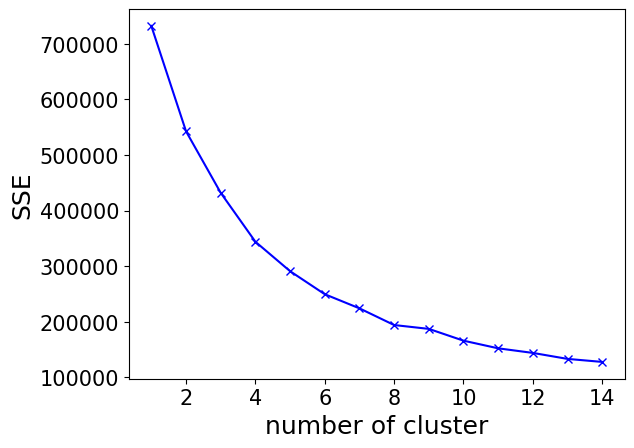

In [14]:
from sklearn.cluster import KMeans
sse_list = [ ] 
K = range(1, 15) 
for k in range(1,15): 
    kmeans=KMeans(n_clusters=k) 
    kmeans.fit(tsne_train_df) 
    sse_list.append(kmeans.inertia_)
    print(sse_list)

plt.figure() 
plt.plot(np.array(K), sse_list, 'bx-')
plt.rcParams['figure.figsize'] = [12,8]
plt.xlabel('number of cluster',fontsize=18)
plt.ylabel('SSE',fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

In [16]:
kmeans = KMeans(n_clusters=10, random_state=0).fit(tsne_train_df)

tsne_train_df_label['kmeans_Cluster'] = kmeans.labels_

kmeans.labels_

array([2, 2, 4, 6, 0, 1, 7, 6, 2, 2, 2, 4, 1, 9, 2, 2, 4, 5, 6, 8, 3, 7,
       8, 0, 0, 3, 7, 8, 4, 4, 9, 8, 6, 3, 0, 0, 0, 0, 3, 5, 0, 9, 2, 0,
       9, 7, 7, 4, 2, 9, 6, 5, 5, 8], dtype=int32)

In [20]:
optics = OPTICS(min_samples=3, xi=0.05, min_cluster_size=0.05)
optics_model = optics.fit_predict(tsne_train_df)
tsne_train_df_label['OPTICS_Cluster'] = optics_model
optics_model

array([-1, -1, -1,  0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1,  2, -1,  3, -1, -1, -1,  3, -1,  2,
        1,  1,  1,  1,  2, -1, -1, -1, -1, -1, -1, -1, -1,  0, -1,  0, -1,
       -1, -1, -1])

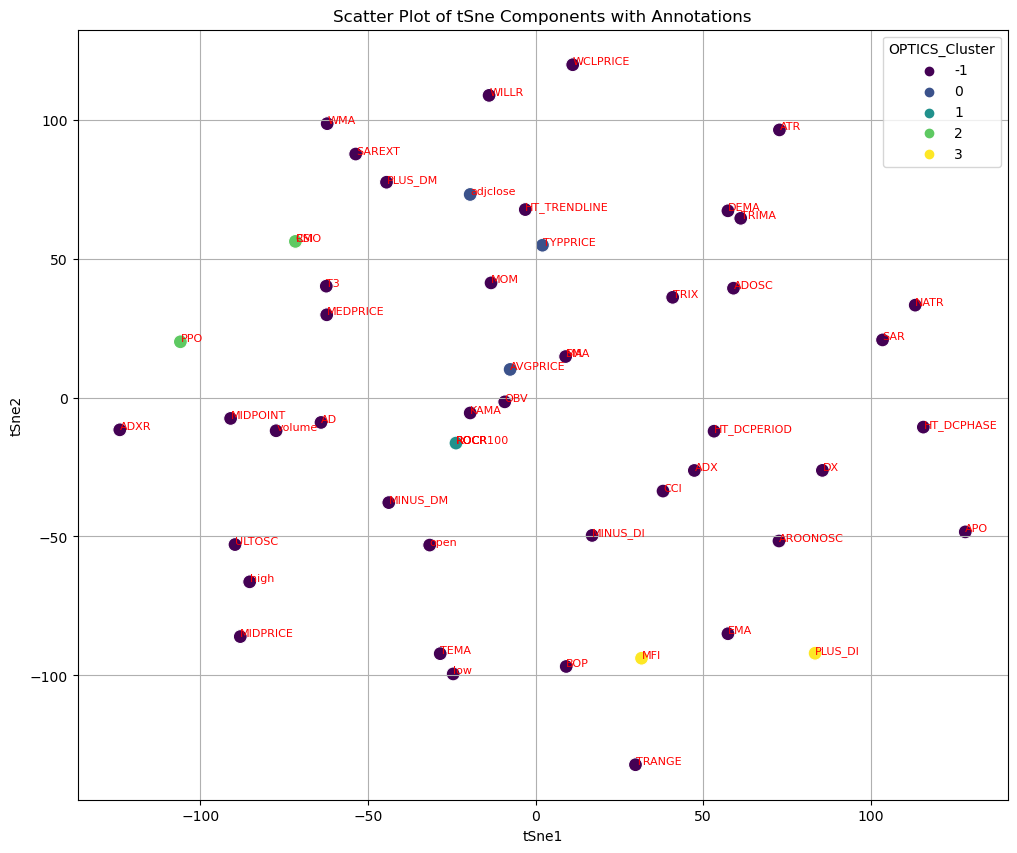

In [23]:
# Creating the plot

plt.figure(figsize=(12, 10))
scatter = sns.scatterplot(x='tSne1', y='tSne2', hue='OPTICS_Cluster', palette='viridis', data=tsne_train_df_label, s=100)

# Annotating each point with its index (symbol and date)
for i, point in tsne_train_df_label.iterrows():
    plt.text(point['tSne1'] + 0.02,  # Adjust the position slightly to avoid overlap
             point['tSne2'] + 0.02,
             f'{i}',
             color='red', fontsize=8)

plt.title('Scatter Plot of tSne Components with Annotations')
plt.xlabel('tSne1')
plt.ylabel('tSne2')
plt.grid(True)
plt.show()


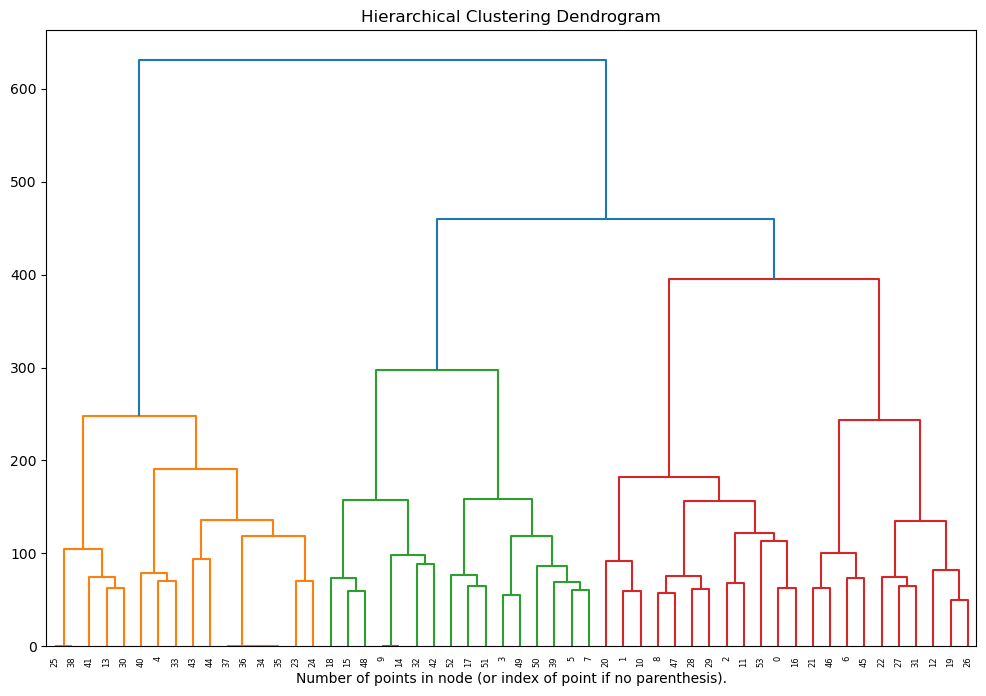

In [26]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)



X = tsne_train_df

# setting distance_threshold=0 ensures we compute the full tree.
Agglomerative_model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

model = Agglomerative_model.fit(X)
plt.title('Hierarchical Clustering Dendrogram')
# plot the top three levels of the dendrogram
plot_dendrogram(Agglomerative_model, truncate_mode='level', p=10)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

The number of clusters is: 6


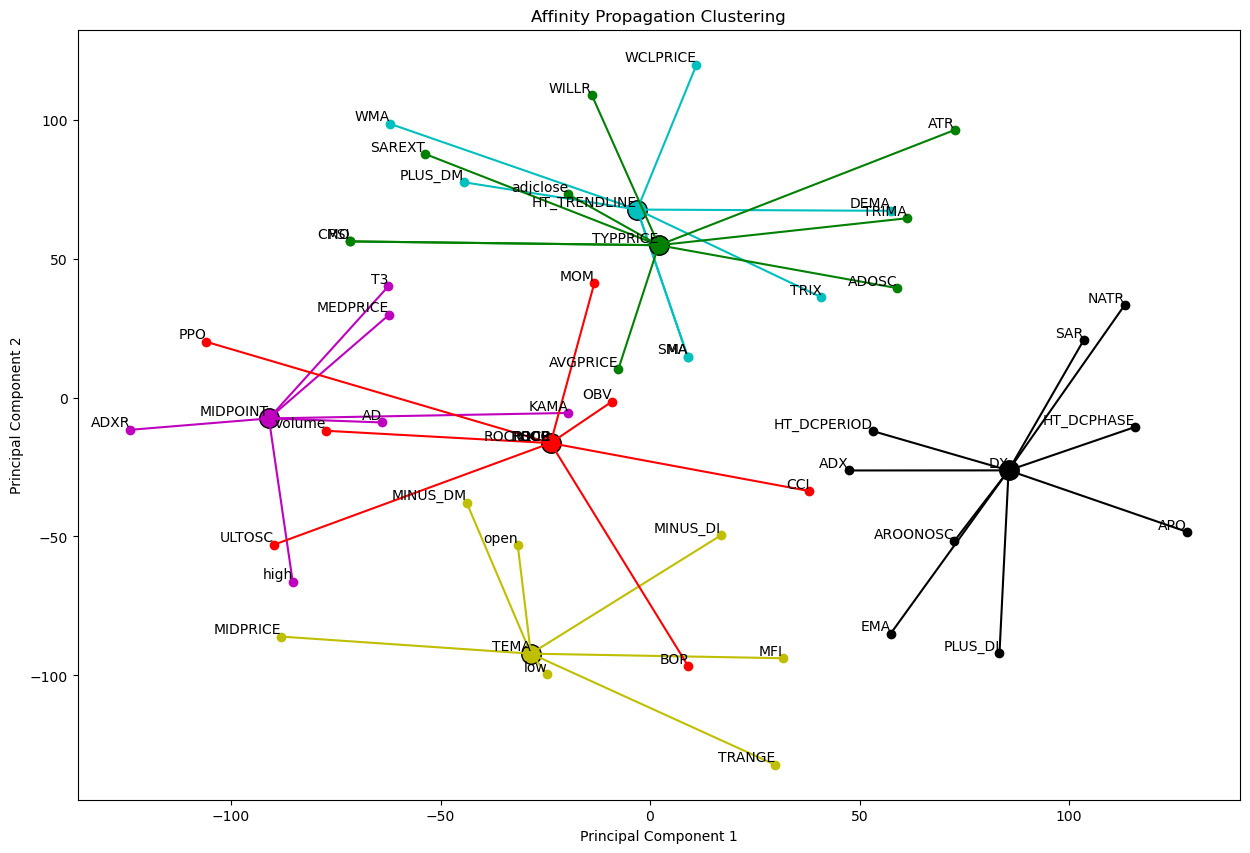

In [27]:
# Assuming pca_train_df is already defined and X is this DataFrame
X = tsne_train_df.values  # Convert DataFrame to numpy array for easier plotting
index_labels = tsne_train_df.index  # Grab the index labels for plotting

# Apply Affinity Propagation
ap = AffinityPropagation(random_state=5)
ap.fit(X)
cluster_centers_indices = ap.cluster_centers_indices_
labels = ap.labels_

tsne_train_df_label['ap_Cluster'] = ap.labels_

# Number of clusters
clusters = len(cluster_centers_indices)
print('The number of clusters is:', clusters)

# Plotting setup
plt.figure(figsize=(15, 10))
colors = cycle('cmykrgbcmykrgbcmykrgbcmykrgb')  # Using the same cycle of colors

# Plot each cluster
for k, col in zip(range(clusters), colors):
    cluster_members = labels == k
    if cluster_centers_indices[k] < X.shape[0]:  # Check if index is valid
        cluster_center = X[cluster_centers_indices[k]]
        plt.plot(X[cluster_members, 0], X[cluster_members, 1], col + '.', markersize=12)
        plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col, markeredgecolor='k', markersize=14)
        for x, idx in zip(X[cluster_members], index_labels[cluster_members]):
            plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)
            plt.text(x[0], x[1], idx, color='black', ha='right', va='bottom')  # Adding index labels to points

plt.title('Affinity Propagation Clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()


In [28]:
# Print the labels of the cluster centers
print("Cluster centers:")
for center_idx in cluster_centers_indices:
    print(index_labels[center_idx])

Cluster centers:
HT_TRENDLINE
MIDPOINT
TEMA
DX
ROCP
TYPPRICE


In [29]:
tsne_train_df_label[['kmeans_Cluster','OPTICS_Cluster','ap_Cluster']]

,kmeans_Cluster,OPTICS_Cluster,ap_Cluster
open,2,-1,2
high,2,-1,1
low,4,-1,2
adjclose,6,0,5
volume,0,-1,4
DEMA,1,-1,0
EMA,7,-1,3
HT_TRENDLINE,6,-1,0
KAMA,2,-1,1
MA,2,-1,0


In [ ]:
# Applying PCA to the standardized training data
# Retain components that explain at least 95% of the variance
pca = PCA(n_components=0.95)
principal_components_train = pca.fit_transform(train_df_standardized_transposed)

# Create a DataFrame for the principal components of the training data
columns = [f'PC{i+1}' for i in range(principal_components_train.shape[1])]
pca_train_df = pd.DataFrame(principal_components_train, index=train_df_standardized_transposed.index, columns=columns)
pca_train_df

In [ ]:
# Creating the plot

plt.figure(figsize=(12, 10))
scatter = sns.scatterplot(x='tSne1', y='tSne2', hue='OPTICS_Cluster', palette='viridis', data=tsne_train_df_label, s=100)

# Annotating each point with its index (symbol and date)
for i, point in tsne_train_df_label.iterrows():
    plt.text(point['tSne1'] + 0.02,  # Adjust the position slightly to avoid overlap
             point['tSne2'] + 0.02,
             f'{i}',
             color='red', fontsize=8)

plt.title('Scatter Plot of PCA Components with Annotations')
plt.xlabel('tSne1')
plt.ylabel('tSne2')
plt.grid(True)
plt.show()
